# How Do My Habits Affect How I Feel?

In [1]:
import pandas as pd 
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
post_name="habits_post5"
save_dir=f"figures/{post_name}"
os.makedirs(save_dir,exist_ok=True)

## Data Access Note

This notebook documents an analysis performed locally on private data.
Raw datasets are not included in this public repository (but will be explained in the data folder).
Code cells that load data are shown for transparency but are not intended to be executed here.

In [3]:
# cleaned_path=Path("/Users/yeshimonipede/Desktop/2025_DataProject/Data/Cleaned")


# am_form = pd.read_pickle(cleaned_path/"am_form_cleaned.pkl")
# pm_form = pd.read_pickle(cleaned_path/"pm_form_cleaned.pkl")
# sleep_rc = pd.read_pickle(cleaned_path/"sleep_rc_cleaned.pkl")
# vitals_rc = pd.read_pickle(cleaned_path/"vitals_rc_cleaned.pkl")
# activity_rc = pd.read_pickle(cleaned_path/"activity_rc_cleaned.pkl")
# habits=pd.read_pickle(cleaned_path/"habits_cleaned.pkl")
# meditation=pd.read_pickle(cleaned_path/"med_day_cleaned.pkl")
# screentime=pd.read_pickle(cleaned_path/"screen_time_cleaned.pkl")

In [4]:
#creating a master df for this analysis 
dfs=[am_form, pm_form, 
     sleep_rc,vitals_rc, activity_rc, habits, meditation, screentime]

merged_df=dfs[0]

#merge the dfs one by one on Date
for df in dfs[1:]:
    merged_df=pd.merge(merged_df, df, on='Date', how='outer')
    

In [5]:
merged_df.columns

Index(['Date', 'DayofWeek', 'Optimism_AM', 'Mind_AM', 'Energy_AM',
       'Priority_AM', 'Workout_Intention', 'Workday', 'Weather_Optimism',
       'How_Well_Prediction_AM', 'Crazy_Prediction_AM', 'Workout_PM',
       'Meditation_PM', 'Fatigue_PM', 'Crazy_PM', 'Mental_PM', 'High_PM',
       'Fun_PM', 'Intention_Satisfaction_PM', 'Satisfied_PM', 'Notes',
       'Start_time', 'Falling_Asleep_Time', 'Wake_Up_Time', 'Sleep_Ratio',
       'TimeAsleep_min', 'Awake(min)', 'REM(min)', 'Light_Sleep(min)',
       'Deep_Sleep(min)', 'HR_avg', 'HR_min', 'HR_max', 'Spo2(%)_avg',
       'Spo2(%)_min', 'Max. Spo2(%)', 'HRV_avg', 'HRV_min', 'HRV_max', 'Steps',
       'Calories(kcal)', 'Clean_5min', 'Journal', 'workout',
       'consume_literature', 'Turkish', 'Creatine', 'Meditation',
       'Screen_Time', 'Instagram', 'TikTok', 'Messages', 'PickUps',
       'Message_notifications', 'Screen_Time_min'],
      dtype='object')

In [6]:
habits=['Clean_5min', 'Journal', 'workout',
       'consume_literature', 'Turkish', 'Creatine', 'Meditation']

outcomes_forms=['Fatigue_PM', 'Crazy_PM', 'Mental_PM',
       'Fun_PM', 'Intention_Satisfaction_PM', 'Satisfied_PM']

physio=["HR_min","HRV_avg"]

## Binarizing days based on whether or not a habit happened

In [11]:
for habit in habits:
    print(f"\n=== {habit} ===")
    # Select rows where habit is 0 or 1
    grouped = merged_df.groupby(habit)[outcomes_forms + physio].mean()
    print(grouped)


=== Clean_5min ===
            Fatigue_PM  Crazy_PM  Mental_PM    Fun_PM  \
Clean_5min                                              
0.0           3.701299  3.610390   3.194805  3.285714   
1.0           3.756098  3.585366   3.317073  3.634146   

            Intention_Satisfaction_PM  Satisfied_PM     HR_min    HRV_avg  
Clean_5min                                                                 
0.0                          3.987013      3.766234  46.439252  71.598131  
1.0                          4.024390      4.073171  45.483871  75.370968  

=== Journal ===
         Fatigue_PM  Crazy_PM  Mental_PM    Fun_PM  Intention_Satisfaction_PM  \
Journal                                                                         
0.0        4.020408  3.959184   3.102041  3.408163                   3.857143   
1.0        3.507246  3.347826   3.333333  3.405797                   4.101449   

         Satisfied_PM     HR_min    HRV_avg  
Journal                                      
0.0          

## Running t-tests on all combinations of habits and outcomes 

In [13]:
from scipy.stats import ttest_ind
results = []

for habit in habits:
    for outcome in outcomes_forms + physio:
        # split data into habit done (1) vs not done (0)
        group1 = merged_df[merged_df[habit] == 1][outcome].dropna()
        group0 = merged_df[merged_df[habit] == 0][outcome].dropna()
        
        # perform t-test
        t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch's t-test
        
        results.append({
            'Habit': habit,
            'Outcome': outcome,
            't_stat': t_stat,
            'p_value': p_val,
            'Mean_Habit_1': group1.mean(),
            'Mean_Habit_0': group0.mean()
        })

# Convert to DataFrame for easy viewing
ttest_df = pd.DataFrame(results)

# Optionally, sort by smallest p-value
ttest_df = ttest_df.sort_values('p_value')

print(ttest_df)

                 Habit                    Outcome    t_stat   p_value  \
38             Turkish                     HR_min -4.234221  0.000041   
15             Journal                    HRV_avg  3.745774  0.000252   
39             Turkish                    HRV_avg  3.595078  0.000490   
9              Journal                   Crazy_PM -3.498309  0.000677   
46            Creatine                     HR_min -2.971908  0.003470   
36             Turkish  Intention_Satisfaction_PM  2.708267  0.008116   
17             workout                   Crazy_PM -2.513486  0.013374   
54          Meditation                     HR_min -2.369298  0.018392   
14             Journal                     HR_min -2.366231  0.019177   
19             workout                     Fun_PM  2.333438  0.021558   
43            Creatine                     Fun_PM  2.283205  0.024262   
21             workout               Satisfied_PM  2.211656  0.029484   
18             workout                  Mental_PM  

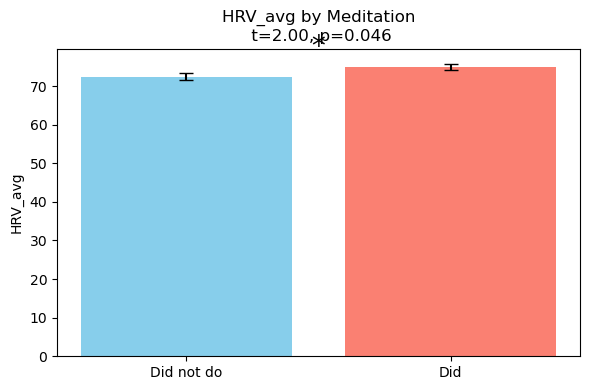

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

def plot_ttest(merged_df, habit, var):
    group0 = merged_df[merged_df[habit]==0][var].dropna()
    group1 = merged_df[merged_df[habit]==1][var].dropna()
    
    # t-test
    t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
    
    means = [group0.mean(), group1.mean()]
    ses = [group0.sem(), group1.sem()]
    
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar([0,1], means, yerr=ses, capsize=5, color=['skyblue','salmon'])
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Did not do', 'Did'])
    ax.set_ylabel(var)
    ax.set_title(f'{var} by {habit}\n t={t_stat:.2f}, p={p_val:.3f}')
    
    # Optional: add significance stars
    if p_val < 0.05:
        ax.text(0.5, max(means)+max(ses)*1.5, '*', ha='center', va='bottom', fontsize=20)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_ttest(merged_df, 'Meditation', 'HRV_avg')

In [14]:
merged_df['PM_morale']=merged_df[["Mental_PM","Satisfied_PM", "Fun_PM", "Intention_Satisfaction_PM"]].mean(axis=1)

In [17]:
test_vars = ['PM_morale']

results = []

for habit in habits:
    for var in test_vars:
        # split data into habit done (1) vs not done (0)
        group1 = merged_df[merged_df[habit] == 1][var].dropna()
        group0 = merged_df[merged_df[habit] == 0][var].dropna()
        
        # perform Welch's t-test
        t_stat, p_val = ttest_ind(group1, group0, equal_var=False)
        
        results.append({
            'Habit': habit,
            'Mean_Habit_1': group1.mean(),
            'Mean_Habit_0': group0.mean(),
            't_stat': t_stat,
            'p_value': p_val
        })

# Convert to DataFrame
ttest_df = pd.DataFrame(results)

# Optional: highlight significant results
ttest_df['Significant'] = ttest_df['p_value'] < 0.05

# Sort by p-value
ttest_df = ttest_df.sort_values('p_value')

print(ttest_df)

                Habit  Mean_Habit_1  Mean_Habit_0    t_stat   p_value  \
2             workout      3.783088      3.420000  2.745272  0.007260   
5            Creatine      3.762295      3.486842  2.113844  0.037069   
0          Clean_5min      3.762195      3.558442  1.475126  0.144160   
3  consume_literature      3.700820      3.552632  1.127767  0.261917   
1             Journal      3.688406      3.545918  1.038576  0.301802   
4             Turkish      3.673077      3.607595  0.529283  0.597752   
6          Meditation      3.686404      3.651515  0.319833  0.749682   

   Significant  
2         True  
5         True  
0        False  
3        False  
1        False  
4        False  
6        False  


In [23]:
habit_var_pairs = {
    'Meditation': ['HRV_avg', 'HR_min'],
    'consume_literature': ['Mental_PM'],
    'Journal': ['Fatigue_PM', 'Crazy_PM'],
    'workout': ['Mental_PM', 'Satisfied_PM', 'Crazy_PM']
}

results = []

for habit, variables in habit_var_pairs.items():
    for var in variables:
        group1 = merged_df[merged_df[habit]==1][var].dropna()
        group0 = merged_df[merged_df[habit]==0][var].dropna()
        pct_diff = (group1.mean() - group0.mean()) / group0.mean() * 100
        
        results.append({
            'Habit': habit,
            'Variable': var,
            '% Difference (Did vs Did Not)': pct_diff
        })

diff_df = pd.DataFrame(results)
print(diff_df)

                Habit      Variable  % Difference (Did vs Did Not)
0          Meditation       HRV_avg                       3.502399
1          Meditation        HR_min                      -1.906698
2  consume_literature     Mental_PM                      11.701526
3             Journal    Fatigue_PM                     -12.763923
4             Journal      Crazy_PM                     -15.441506
5             workout     Mental_PM                      12.485392
6             workout  Satisfied_PM                      11.102133
7             workout      Crazy_PM                     -11.612313


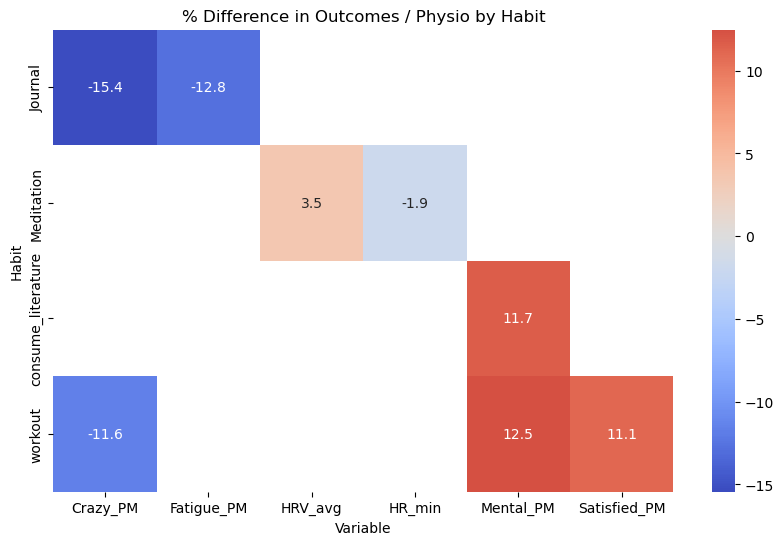

In [24]:
import seaborn as sns

# Pivot table for heatmap
heatmap_data = diff_df.pivot(index='Habit', columns='Variable', values='% Difference (Did vs Did Not)')

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='coolwarm', center=0)
plt.title('% Difference in Outcomes / Physio by Habit')
plt.show()